In [124]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd="C:\\Program Files\\Tesseract-OCR\\tesseract.exe"
import seaborn as sns

from skimage.feature import hog
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# I. Pre-processing

## 1. Image Loading

In [71]:
def load_images(dossier:str) :
    images = list()
    for file in os.listdir(dossier) :
        path = os.path.join(dossier, file)
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (1000,1000))
        images.append(img)
    return images

In [209]:
MANg4g4   =  load_images("./DATA/MAN/4-4")
MANg4g8   =  load_images("./DATA/MAN/4-8")
MANg4g16  =  load_images("./DATA/MAN/4-16")
MANg8g8   =  load_images("./DATA/MAN/8-8")
MANg8g16  =  load_images("./DATA/MAN/8-16")
MANg8g32  =  load_images("./DATA/MAN/8-32")
MANg16g4  =  load_images("./DATA/MAN/16-4")
MANg16g8  =  load_images("./DATA/MAN/16-8")
MANg16g16 =  load_images("./DATA/MAN/16-16")
MANg16g64 =  load_images("./DATA/MAN/16-64")
MANg32g16 =  load_images("./DATA/MAN/32-16")
MANg32g32 =  load_images("./DATA/MAN/32-32")
MANg64g64 =  load_images("./DATA/MAN/64-64")

In [210]:
MAN4 = MANg4g4 + MANg4g8 + MANg4g16
MAN8 = MANg8g8 + MANg8g16 + MANg8g32
MAN16 = MANg16g8 + MANg16g4 + MANg16g16 + MANg16g64
MAN32 = MANg32g16 + MANg32g32
MAN64 = MANg64g64

In [211]:
# NMRg16g32 = load_images("./DATA/NMR/16-32")
# NMRg16g64 = load_images("./DATA/NMR/16-64")
# NMRg32g16 = load_images("./DATA/NMR/32-16")
# NMRg32g64 = load_images("./DATA/NMR/32-64")

## 2. Contour Detection

In [212]:
lower_blue = np.array([80, 5, 5])
upper_blue = np.array([150, 255, 255])

In [213]:
def cntr_find(imgs:list) -> list:
    points = list()
    for i in range(len(imgs)):
        img0 = imgs[i].copy()
        img1 = imgs[i].copy()
        img2 = imgs[i].copy()

        hsv = cv.cvtColor(imgs[i], cv.COLOR_RGB2HSV)      
        mask = cv.inRange(hsv, lower_blue, upper_blue)
        contours ,_ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv.contourArea)

        contouredimg=imgs[i].copy()
        cv.drawContours(contouredimg, [largest_contour], -1, (191,213,229),thickness=cv.FILLED)
        blured_img = cv.cvtColor(cv.medianBlur(contouredimg, 3), cv.COLOR_RGB2GRAY)
        _,th = cv.threshold(blured_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv.contourArea)
        contoured_img2= cv.drawContours(img0, [max_contour], -1, (0, 255, 0), 2)

        hull = cv.convexHull(max_contour)
        epsilon = 0.02 * cv.arcLength(hull, True)
        approx = cv.approxPolyDP(hull, epsilon, True)

        points.append(approx)
    return points

In [214]:
MANg4g4_pts = cntr_find(MANg4g4)
MANg4g8_pts = cntr_find(MANg4g8)
MANg4g16_pts = cntr_find(MANg4g16)
MANg8g8_pts = cntr_find(MANg8g8)
MANg8g16_pts = cntr_find(MANg8g16)
MANg8g32_pts = cntr_find(MANg8g32)
MANg16g4_pts = cntr_find(MANg16g4)
MANg16g8_pts = cntr_find(MANg16g8)
MANg16g16_pts = cntr_find(MANg16g16)
MANg16g64_pts = cntr_find(MANg16g64)
MANg32g16_pts = cntr_find(MANg32g16)
MANg32g32_pts = cntr_find(MANg32g32)
MANg64g64_pts = cntr_find(MANg64g64)

## 3. Boxing the images

In [215]:
def box_img(pts:list, img:list) -> list:
    box = list()
    output = np.float32([[0,0],[519,0],[519,519],[0,519]])
    for i in range(len(pts)):
        approx = np.float32(pts[i])
        approx = np.reshape(approx,(4,2))
        M = cv.getPerspectiveTransform(approx, output)
        out = cv.warpPerspective(img[i],M,(520, 520),flags=cv.INTER_LINEAR)
        box.append(out)
    return box

In [216]:
MANg4g4_edg = box_img(MANg4g4_pts, MANg4g4)
MANg4g8_edg = box_img(MANg4g8_pts, MANg4g8)
MANg4g16_edg = box_img(MANg4g16_pts, MANg4g16)
MANg8g8_edg = box_img(MANg8g8_pts, MANg8g8)
MANg8g16_edg = box_img(MANg8g16_pts, MANg8g16)
MANg8g32_edg = box_img(MANg8g32_pts, MANg8g32)
MANg16g4_edg = box_img(MANg16g4_pts, MANg16g4)
MANg16g8_edg = box_img(MANg16g8_pts, MANg16g8)
MANg16g16_edg = box_img(MANg16g16_pts, MANg16g16)
MANg16g64_edg = box_img(MANg16g64_pts, MANg16g64)
MANg32g16_edg = box_img(MANg32g16_pts, MANg32g16)
MANg32g32_edg = box_img(MANg32g32_pts, MANg32g32)
MANg64g64_edg = box_img(MANg64g64_pts, MANg64g64)

## 4. Image equalization

In [217]:
def equalizer(img:list) -> list:
    new_img = list()
    for i in range(len(img)):
        b, g, r = cv.split(img[i])

        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        b_clahe = clahe.apply(b)
        g_clahe = clahe.apply(g)
        r_clahe = clahe.apply(r)

        image_clahe = cv.merge((b_clahe, g_clahe, r_clahe))
        new_img.append(image_clahe)
    return new_img

In [218]:
MANg4g4_cla = equalizer(MANg4g4_edg)
MANg4g8_cla = equalizer(MANg4g8_edg)
MANg4g16_cla = equalizer(MANg4g16_edg)
MANg8g8_cla = equalizer(MANg8g8_edg)
MANg8g16_cla = equalizer(MANg8g16_edg)
MANg8g32_cla = equalizer(MANg8g32_edg)
MANg16g4_cla = equalizer(MANg16g4_edg)
MANg16g8_cla = equalizer(MANg16g8_edg)
MANg16g16_cla = equalizer(MANg16g16_edg)
MANg16g64_cla = equalizer(MANg16g64_edg)
MANg32g16_cla = equalizer(MANg32g16_edg)
MANg32g32_cla = equalizer(MANg32g32_edg)
MANg64g64_cla = equalizer(MANg64g64_edg)

## 5. Image rotation

In [219]:
lower_red_orange = np.array([0, 120, 50])
upper_red_orange = np.array([5, 255, 255])

In [220]:
def mask_red_orange(image_path):
    image = image_path.copy()
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    mask = cv.inRange(hsv, lower_red_orange, upper_red_orange)

    result = cv.bitwise_and(image, image, mask=mask)
    return result

In [221]:
def rotate(img:list) -> list:
    limage = list()
    for i in range(len(img)):
        immg = mask_red_orange(img[i])
        r, g, b = cv.split(immg)
        corner = list()
        corner.append(np.float32(r[0:120,400:519]).mean())
        corner.append(np.float32(r[0:120,0:150]).mean())
        corner.append(np.float32(r[400:519,0:120]).mean())
        corner.append(np.float32(r[400:519,400:519]).mean())
        hh = corner.index(max(corner))
    
        h, w = immg.shape[:2]
        center = (w // 2, h // 2)

        rotation_matrix = cv.getRotationMatrix2D(center, hh*-90, 1.0)
        new_image = np.zeros((h, w, immg.shape[2]), dtype=np.uint8)

        new_img = cv.warpAffine(img[i], rotation_matrix, (w, h), dst=new_image, flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE) 
        limage.append(new_img)
    return limage

In [222]:
MANg4g4_rot = rotate(MANg4g4_cla)
MANg4g8_rot = rotate(MANg4g8_cla)
MANg4g16_rot = rotate(MANg4g16_cla)
MANg8g8_rot = rotate(MANg8g8_cla)
MANg8g16_rot = rotate(MANg8g16_cla)
MANg8g32_rot = rotate(MANg8g32_cla)
MANg16g4_rot = rotate(MANg16g4_cla)
MANg16g8_rot = rotate(MANg16g8_cla)
MANg16g16_rot = rotate(MANg16g16_cla)
MANg16g64_rot = rotate(MANg16g64_cla)
MANg32g16_rot = rotate(MANg32g16_cla)
MANg32g32_rot = rotate(MANg32g32_cla)
MANg64g64_rot = rotate(MANg64g64_cla)

## 6. Get num

In [236]:
def get_num(img:list) -> list:
    num = list()
    for i in range(len(img)):
        hh = img[i][180:265,330:435]
        thres , black = cv.threshold(hh, 90, 255, cv.THRESH_BINARY)
        num.append(black)
    return num

In [237]:
MANg4g4_num = get_num(MANg4g4_rot)
MANg4g8_num = get_num(MANg4g8_rot)
MANg4g16_num = get_num(MANg4g16_rot)
MANg8g8_num = get_num(MANg8g8_rot)
MANg8g16_num = get_num(MANg8g16_rot)
MANg8g32_num = get_num(MANg8g32_rot)
MANg16g4_num = get_num(MANg16g4_rot)
MANg16g8_num = get_num(MANg16g8_rot)
MANg16g16_num = get_num(MANg16g16_rot)
MANg16g64_num = get_num(MANg16g64_rot)
MANg32g16_num = get_num(MANg32g16_rot)
MANg32g32_num = get_num(MANg32g32_rot)
MANg64g64_num = get_num(MANg64g64_rot)

In [238]:
def im_show(img:list):
    fig,(a)=plt.subplots(1,int(len(img)/1),figsize=(16,8))
    for i in range(len(img)):
        a[i].imshow(img[i], 'gray')

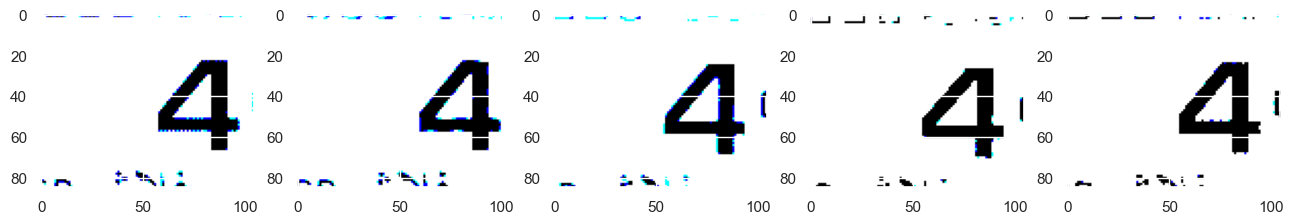

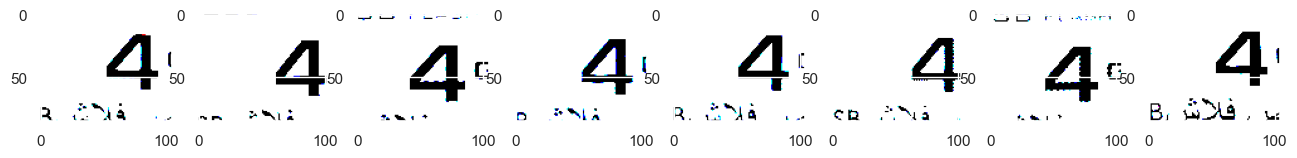

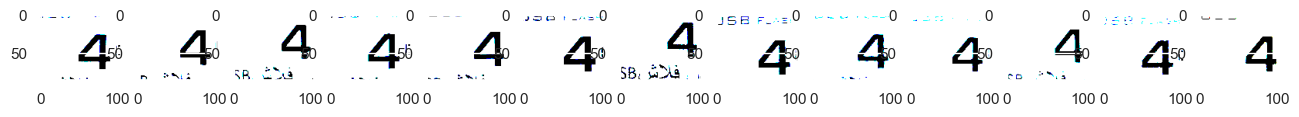

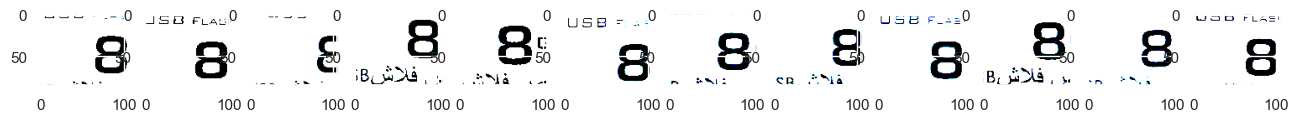

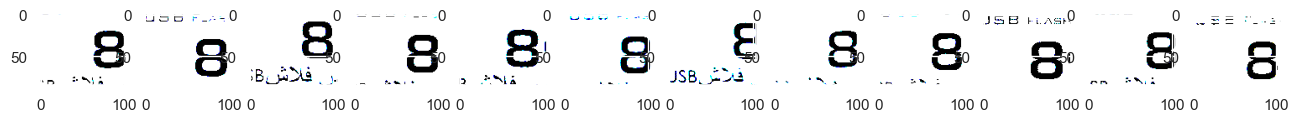

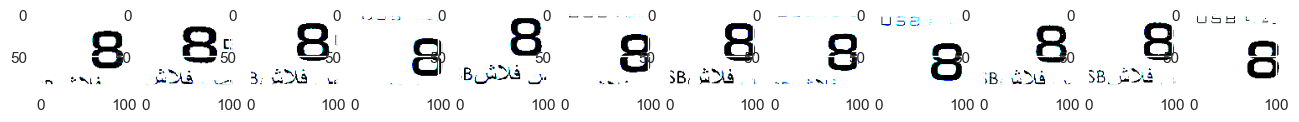

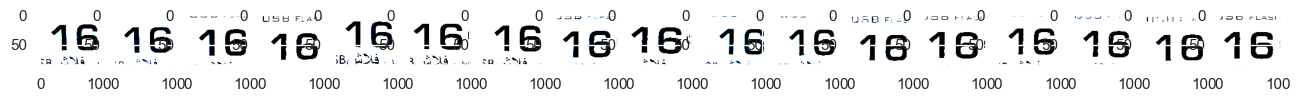

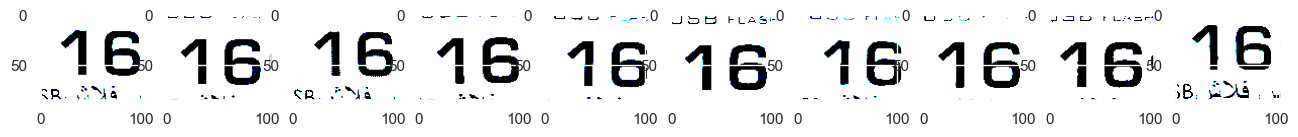

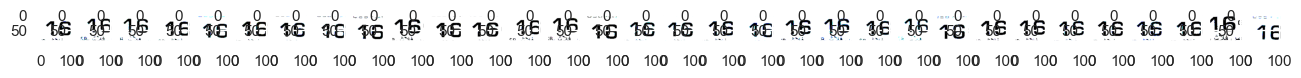

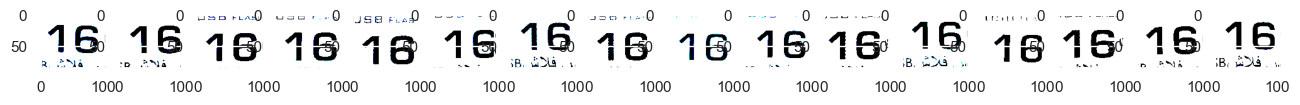

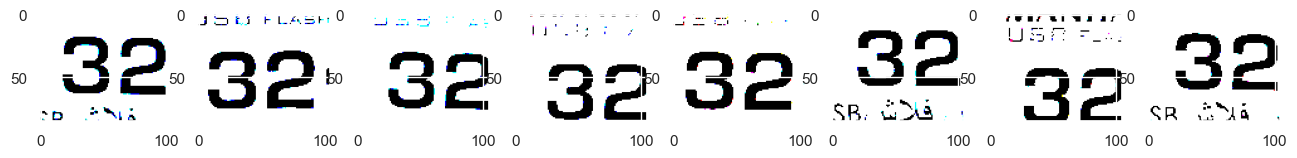

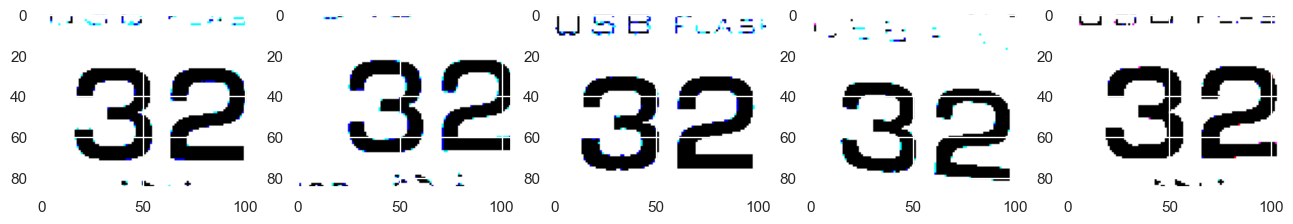

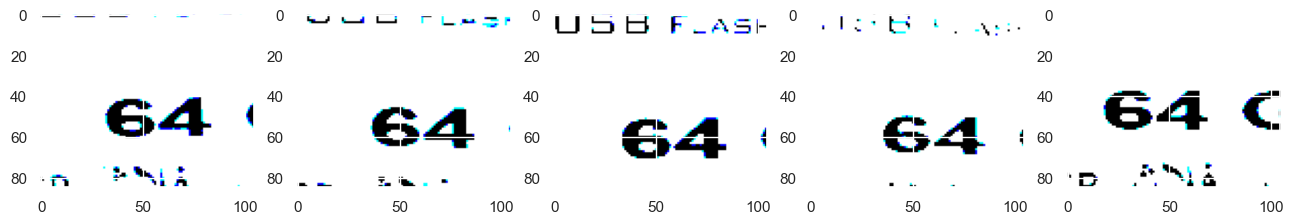

In [239]:
im_show(MANg4g4_num)
im_show(MANg4g8_num)
im_show(MANg4g16_num)
im_show(MANg8g8_num)
im_show(MANg8g16_num)
im_show(MANg8g32_num)
im_show(MANg16g4_num)
im_show(MANg16g8_num)
im_show(MANg16g16_num)
im_show(MANg16g64_num)
im_show(MANg32g16_num)
im_show(MANg32g32_num)
im_show(MANg64g64_num)

# II. KNNs

In [242]:
MAN4_num = MANg4g4_num + MANg4g8_num + MANg4g16_num
MAN8_num = MANg8g8_num + MANg8g16_num + MANg8g32_num
MAN16_num = MANg16g8_num + MANg16g4_num + MANg16g16 + MANg16g64_num
MAN32_num = MANg32g16_num + MANg32g32_num
MAN64_num = MANg64g64_num

## 1. Using hog (Histogram oriented gradient)

In [243]:
def hogg(imgs:list) :
    fv = list()
    hog_img = list()
    for i in range(len(imgs)) :
        fv_i, hog_i = hog(imgs[i], orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, channel_axis=-1)
        fv.append(fv_i)
        hog_img.append(hog_i)
    return fv, hog_img

In [244]:
fv_MAN4, hog_MAN4 = hogg(MAN4_num)
fv_MAN8, hog_MAN8 = hogg(MAN8_num)
fv_MAN16, hog_MAN16 = hogg(MAN16_num)
fv_MANg32, hog_MAN32 = hogg(MAN32_num)
fv_MAN64, hog_MAN64 = hogg(MAN64_num)

## 2. Image labeling

In [245]:
def labeling(imgs:list, label:int):
    lab = list()
    for i in range(len(imgs)):
        lab.append(label)
    return lab

In [246]:
lab_4 = labeling(fv_MAN4, 0)
lab_8 = labeling(fv_MAN8, 1)
lab_16 = labeling(fv_MAN16, 2)
lab_32 = labeling(fv_MANg32, 3)
lab_64 = labeling(fv_MAN64, 4)

fv = fv_MAN4 + fv_MAN8 + fv_MAN16 + fv_MANg32 + fv_MAN64
labels = lab_4 + lab_8 + lab_16 + lab_32 + lab_64

In [247]:
fv = pd.DataFrame(fv)
fv.head()

,0,1,2,3,4,5,6,7,8,9,...,553526,553527,553528,553529,553530,553531,553532,553533,553534,553535
0,0.433861,0.0,0.0,0.0,0.433861,0.0,0.433861,0.0,0.0,0.433861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.408248,0.0,0.0,0.0,0.408248,0.0,0.408248,0.0,0.0,0.408248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.427526,0.0,0.0,0.0,0.516188,0.0,0.201538,0.0,0.0,0.516188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.267548,0.0,0.0,0.0,0.542404,0.0,0.189185,0.0,0.0,0.542404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.155568,0.0,0.0,0.0,0.526178,0.0,0.220006,0.0,0.0,0.526178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
fv = fv.dropna(axis=1)

In [249]:
fv.head()

,0,1,2,3,4,5,6,7,8,9,...,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887
0,0.433861,0.0,0.0,0.0,0.433861,0.0,0.433861,0.0,0.0,0.433861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.408248,0.0,0.0,0.0,0.408248,0.0,0.408248,0.0,0.0,0.408248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.427526,0.0,0.0,0.0,0.516188,0.0,0.201538,0.0,0.0,0.516188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.267548,0.0,0.0,0.0,0.542404,0.0,0.189185,0.0,0.0,0.542404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.155568,0.0,0.0,0.0,0.526178,0.0,0.220006,0.0,0.0,0.526178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. KNNs Training

In [298]:
fv_train, fv_test, lab_train, lab_test = train_test_split(fv, labels, test_size=0.6, random_state=42)

In [299]:
para = {'n_neighbors': np.arange(1,12,2), 'p' : np.arange(1,4,1)}

knn = KNeighborsClassifier()

clf = GridSearchCV(estimator=knn, param_grid=para, scoring='accuracy')
clf.fit(fv_train, lab_train)

c:\Users\thehi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11]),
                         'p': array([1, 2, 3])},
             scoring='accuracy')

In [300]:
clf.best_params_

{'n_neighbors': 1, 'p': 2}

In [301]:
knn = KNeighborsClassifier(**clf.best_params_)

knn.fit(fv_train, lab_train)

KNeighborsClassifier(n_neighbors=1)

In [302]:
N, train_score, val_score = learning_curve(knn, fv_train, lab_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)

c:\Users\thehi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


## 4. Results

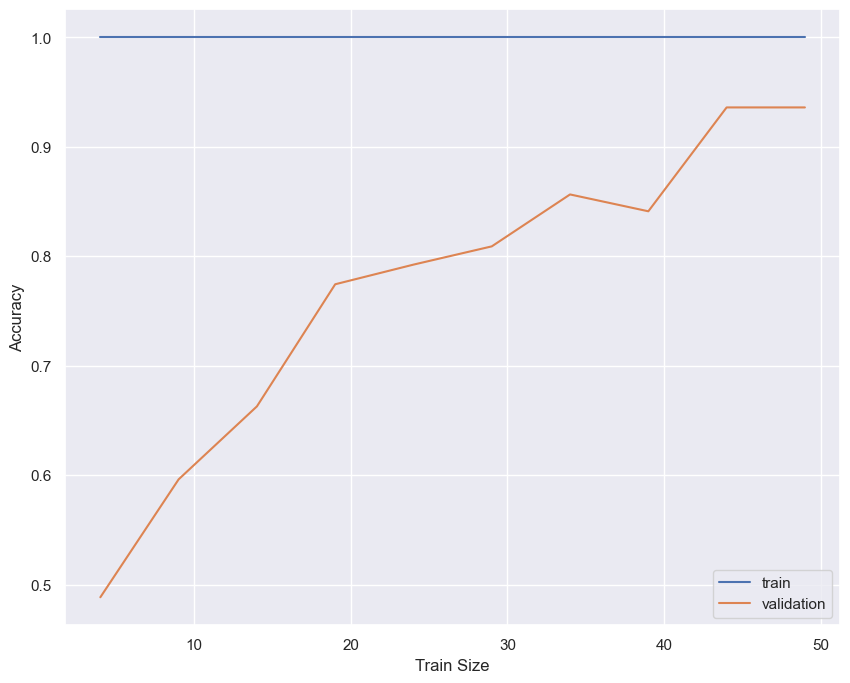

In [303]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,8))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()

In [304]:
yknn = knn.predict(fv_test)
print("Accuracy is {:.2f}%".format(metrics.accuracy_score(lab_test, yknn)*100))

Accuracy is 87.10%


<function matplotlib.pyplot.show(close=None, block=None)>

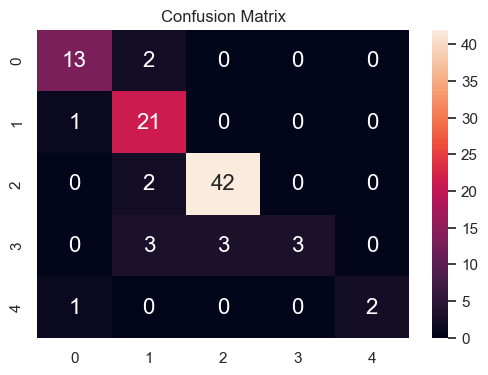

In [305]:
plt.figure(figsize=(6,4))
sns.heatmap(metrics.confusion_matrix(lab_test, yknn), annot=True, annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.show